# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [11]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [12]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [13]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False, stop_words={'english'}, lowercase=bool, ngram_range=(1, 2))
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [14]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/macintosh/Desktop/ml-master/data/moviereviews_train.tsv', my_random_seed=24)

print("Number of fits stored in `fitted_transformations` list: ") 
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [15]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/macintosh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 9992, 'Neg': 10008, 'TP': 2951, 'TN': 6812, 'FP': 3196, 'FN': 7041, 'Accuracy': 0.48815, 'Precision': 0.480071579632341, 'Recall': 0.29533626901521215, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [16]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [37]:
from sklearn import linear_model
svm1 = linear_model.SGDClassifier(alpha=0.0001)
svm1.fit(X_train, y_train)

svm_performance_train1 = BinaryClassificationPerformance(svm1.predict(X_train), y_train, 'svm_train1')
svm_performance_train1.compute_measures()
print(svm_performance_train1.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train1'}


In [38]:
from sklearn import linear_model
svm2 = linear_model.SGDClassifier(alpha=0.5)
svm2.fit(X_train, y_train)

svm_performance_train2 = BinaryClassificationPerformance(svm2.predict(X_train), y_train, 'svm_train2')
svm_performance_train2.compute_measures()
print(svm_performance_train2.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train2'}


In [39]:
from sklearn import linear_model
svm3 = linear_model.SGDClassifier(alpha=1)
svm3.fit(X_train, y_train)

svm_performance_train3 = BinaryClassificationPerformance(svm3.predict(X_train), y_train, 'svm_train3')
svm_performance_train3.compute_measures()
print(svm_performance_train3.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train3'}


In [40]:
from sklearn import linear_model
svm4 = linear_model.SGDClassifier(alpha=45)
svm4.fit(X_train, y_train)

svm_performance_train4 = BinaryClassificationPerformance(svm4.predict(X_train), y_train, 'svm_train4')
svm_performance_train4.compute_measures()
print(svm_performance_train4.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9987, 'TN': 10007, 'FP': 1, 'FN': 5, 'Accuracy': 0.9997, 'Precision': 0.999899879855827, 'Recall': 0.9994995996797438, 'desc': 'svm_train4'}


In [41]:
from sklearn import linear_model
svm5 = linear_model.SGDClassifier(alpha=120)
svm5.fit(X_train, y_train)
5
svm_performance_train5 = BinaryClassificationPerformance(svm5.predict(X_train), y_train, 'svm_train5')
svm_performance_train5.compute_measures()
print(svm_performance_train5.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9960, 'TN': 10007, 'FP': 1, 'FN': 32, 'Accuracy': 0.99835, 'Precision': 0.9998996084730448, 'Recall': 0.9967974379503602, 'desc': 'svm_train5'}


### MODEL: logistic regression

In [17]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [20]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [19]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [366]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 8034, 'TN': 7103, 'FP': 2905, 'FN': 1958, 'Accuracy': 0.75685, 'Precision': 0.734436420148094, 'Recall': 0.8040432345876701, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

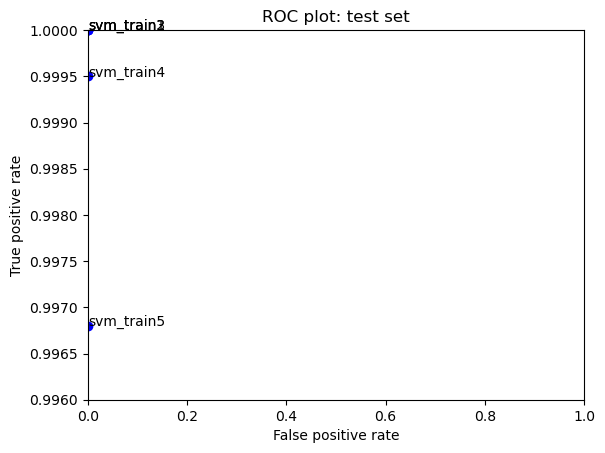

In [45]:
fits = [svm_performance_train1,svm_performance_train2,svm_performance_train3,svm_performance_train4,svm_performance_train5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.996, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [222]:
nbs_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [223]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
70
The title creatures wreak havoc at a peaceful little desert town. That's basically the whole plot for this film, and while the scenes devoted to the Munchies themselves are somewhat fun (in a lowbrow kind of way), all the rest is just filler, and bad filler at that. From the \hero\", who is a painful Woody Allen wannabe, to the ultra-dumb town cop, it's hard to pick the most irritating character in the film. There were some times when almost all of them were on the screen together and I was thinking, \"OK, at least the girlfriend is cute, but why do we have to put up with the rest of those morons?\". The film is also filled with pop references (from Ozzy Osbourne to Linda Blair), which probably made it already dated by the early 90's. (*1/2)"
* * * * * * * * * 
77
\The 700 Club\" has to be the single most bigoted television program in the history of television itself. To make matters worse, it's been on the air since 1966, implying that thousands if not 

2845
This is one of those movies in which people keep saying \That's a great idea!\" about the worst ideas you've ever heard. Then they act on them. I like it. This picture's funnier than any 3 dozen Seth Rogen projects. Well, so is SHOAH. <br /><br />Gojira movies have been cannibalizing their own origin-stories since the 60s, but this one goes further. What can you say about a culture willing to rape its own sacred cultural icons for a quick buck? This travesty presents a WW2 suicide brigade on \"the last of the Marshall Islands\" presenting arms to a dinosaur who chased the US Marines away. Then the Japanese inexplicably decide not to fight to the last man, and instead abandon the territory annexed on their behalf by this giant lizard. They retreat to the mainland, where one of them becomes a business tycoon.<br /><br />Then it gets complicated.<br /><br />Blonde men from the future, irritable over not yet curing male pattern baldness, come back in time in a sort of flying saucer to

6317
It saddens me to rate a movie with a lot of my favorite actors, locations and genres, i.e. Douglas, Sutherland, Washington, D.C. and political thriller, but 'The Sentinel' really hits a low. It's like they had a great idea up front, signed the right cast and had some great city shots and then took a holiday letting the remaining crew improvise the rest. And I wish I could blame it on yet another bland performance from Basinger (not only do I feel she's one of the worst actors in Hollywood, but I'm still steaming more than a decade later that she was the only one, and definitely the only bad actor in the film, to win an acting Oscar for 'L.A. Confidential.') But she wasn't the only problem. Sutherland, who I love as Jack Bauer on '24' once again playsJack. I miss his old 'A Time to Kill' or 'A Few Good Men' days. Douglas certainly took a hiatus from acting and phoned this one in. Plot: Someone, some Secret Service traitor, wants the President dead and Douglas is (haphazardly) bein

9977
this movie was banned in england? why? tom savini, george romero, dario argento, lucio fulci and others had done far worse before and have continued to so since...<br /><br />this movie has all the basic elements of a decent 70s or early 80's horror film. good looking girls (who can't act to save their lives, by the way), a terrible lightning storm with a torrential downpour, a scythe, a crazy brother wandering around the family estate, and actually a pretty damn good twist at the end. but banned? seriously. when the English parliament banned this movie, the italians probably laughed their collective asses off at how backwards and prudish the brits really were.<br /><br />there was maybe two minutes of total screen time devoted to the violence and gore (which was greatly underdone). there was nudity but no sex although allusions to sex were made, obviously. but absolutely nothing worthy of being banned.<br /><br />i would like to see what could have been done if the filmmakers had

14199
The John Goodman program was pretty awful, but this thing just plain stinks. The one and only thing in this mess that made me smile was recognizing the voice of Patrick Starfish as Frosty. The story is hopeless, written by somebody who has garbled memories of childhood rebelliousness but has never gained any adult sense of perspective in the intervening years. Paranoia rules the dark world that these characters inhabit. Everybody is unpleasant, and for no reason. The plot is predictable but the show lurches from one inexplicable, unconnected scene to another in such a pointless way there is no fun in watching it. The worst thing is nobody in the production crew seems to have ever seen snow!
* * * * * * * * * 
14210
You, know, I can take the blood and the sex, but that thong bikini shot pretty much did me in. Someone get that girl some pasta before it's too late!<br /><br />And you know, it's just not a good idea for a schlock movie to start off by mentioning the much better movie

17989
The number of goofs in this episode was higher than the first 9. They don't follow their own rules about spirits where destruction of the body makes the spirit dissolve. This one dropped a second body. That body, and Dean, drop about 20 feet from Sam but then they are right with Sam. Flashlights go out in an unlighted asylum, at night, and we can still see everything. It's night but light is streaming through the windows. A ghost that died in 1960's is making cell phones calls? Come on! There is no way Sam could get a psychiatrist to see him in the same day he makes an appointment and the doctor talks to Sam like it wasn't his first visit. Sam and Dean knew there were other bodies in the asylum and innocent spirits still lurking and didn't do anything to help them. That doesn't seem like a thing the Winchester boys would do. Oh and after crawling around on a dirt filled mattress and all around a nasty asylum the girls' makeup and hair is perfect and not a smudge on her white shir

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [46]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 669, 'TN': 1770, 'FP': 722, 'FN': 1839, 'Accuracy': 0.4878, 'Precision': 0.4809489575844716, 'Recall': 0.26674641148325356, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [47]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2248, 'TN': 2195, 'FP': 297, 'FN': 260, 'Accuracy': 0.8886, 'Precision': 0.8833005893909627, 'Recall': 0.8963317384370016, 'desc': 'svm_test'}


In [49]:
svm_performance_test1 = BinaryClassificationPerformance(svm1.predict(X_test), y_test, 'svm_test1')
svm_performance_test1.compute_measures()
print(svm_performance_test1.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2072, 'TN': 2064, 'FP': 428, 'FN': 436, 'Accuracy': 0.8272, 'Precision': 0.8288, 'Recall': 0.8261562998405104, 'desc': 'svm_test1'}


In [52]:
svm_performance_test2 = BinaryClassificationPerformance(svm2.predict(X_test), y_test, 'svm_test2')
svm_performance_test2.compute_measures()
print(svm_performance_test2.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2212, 'TN': 2170, 'FP': 322, 'FN': 296, 'Accuracy': 0.8764, 'Precision': 0.8729281767955801, 'Recall': 0.8819776714513556, 'desc': 'svm_test2'}


In [53]:
svm_performance_test3 = BinaryClassificationPerformance(svm3.predict(X_test), y_test, 'svm_test3')
svm_performance_test3.compute_measures()
print(svm_performance_test3.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2234, 'TN': 2217, 'FP': 275, 'FN': 274, 'Accuracy': 0.8902, 'Precision': 0.8903945795137505, 'Recall': 0.8907496012759171, 'desc': 'svm_test3'}


In [54]:
svm_performance_test4 = BinaryClassificationPerformance(svm4.predict(X_test), y_test, 'svm_test4')
svm_performance_test4.compute_measures()
print(svm_performance_test1.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2072, 'TN': 2064, 'FP': 428, 'FN': 436, 'Accuracy': 0.8272, 'Precision': 0.8288, 'Recall': 0.8261562998405104, 'desc': 'svm_test1'}


In [55]:
svm_performance_test5 = BinaryClassificationPerformance(svm5.predict(X_test), y_test, 'svm_test5')
svm_performance_test5.compute_measures()
print(svm_performance_test5.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2097, 'TN': 2277, 'FP': 215, 'FN': 411, 'Accuracy': 0.8748, 'Precision': 0.9070069204152249, 'Recall': 0.8361244019138756, 'desc': 'svm_test5'}


### MODEL: logistic regression

In [48]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2054, 'TN': 2054, 'FP': 438, 'FN': 454, 'Accuracy': 0.8216, 'Precision': 0.8242375601926164, 'Recall': 0.8189792663476874, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [245]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1976, 'TN': 1772, 'FP': 720, 'FN': 532, 'Accuracy': 0.7496, 'Precision': 0.7329376854599406, 'Recall': 0.7878787878787878, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [246]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2118, 'TN': 2057, 'FP': 435, 'FN': 390, 'Accuracy': 0.835, 'Precision': 0.8296122209165687, 'Recall': 0.8444976076555024, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [439]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2293, 'TN': 2191, 'FP': 301, 'FN': 215, 'Accuracy': 0.8968, 'Precision': 0.8839629915188898, 'Recall': 0.914274322169059, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [247]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1964, 'TN': 1733, 'FP': 759, 'FN': 544, 'Accuracy': 0.7394, 'Precision': 0.7212633125229526, 'Recall': 0.7830940988835726, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

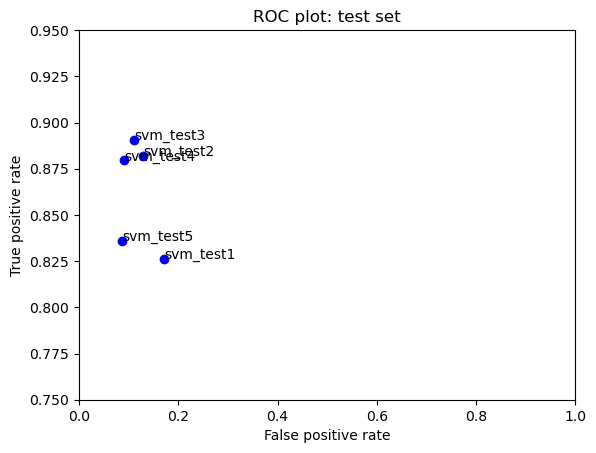

In [61]:
fits = [svm_performance_test1,svm_performance_test2,svm_performance_test3,svm_performance_test4,svm_performance_test5]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.75, 0.95])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [62]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/macintosh/Desktop/ml-master/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Siz

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [77]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5056


In [78]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [79]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [80]:
my_submission.shape

(25000, 2)

In [81]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/macintosh/Desktop/ml-master/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation